In [1]:
%matplotlib inline

from pathlib import Path
import io
import urllib.parse as urlparse
import string
import random

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import trange
from tqdm.auto import tqdm
import requests
from scrapy.http import TextResponse
from PIL import Image

model_dir = Path("/home/hadim/.data/Neural_Network/captchanet/model/")

model_name = 'v5'
model_path = model_dir / model_name
tokenizer_path = model_path / 'tokenizer.json'

---
Download random images and run the model on it. Here we don't have access to the true captcha label.

W0711 19:02:03.508085 140584611587904 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0711 19:02:04.131207 140584611587904 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0711 19:02:15.168211 140584611587904 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


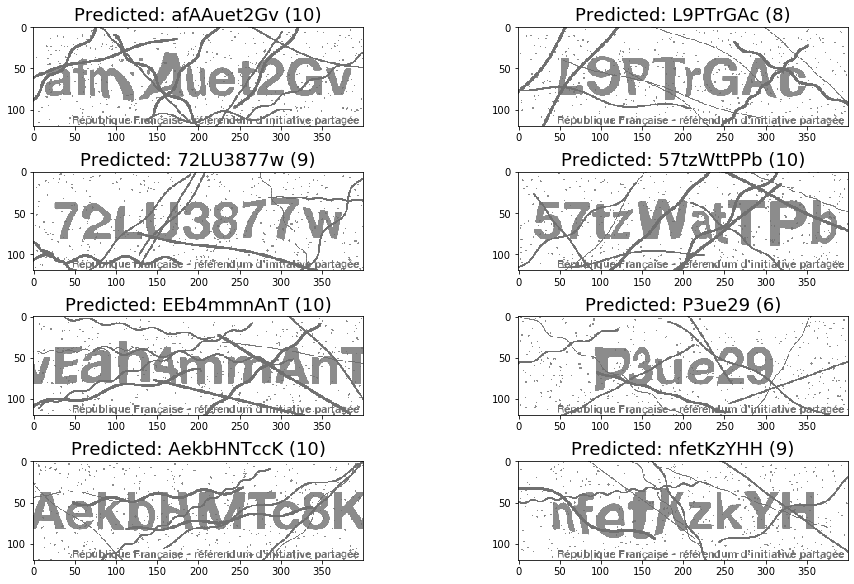

In [2]:
# Test predictions on randomly downloaded captcha images.

# Load tokenizer and model
with open(model_path / 'tokenizer.json') as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())
model = tf.keras.models.load_model(str(model_path))

# Download images
batch_size = 8
captcha_url = "https://www.referendum.interieur.gouv.fr/bundles/ripconsultation/securimage/securimage_show.php"
images = [np.array(Image.open(io.BytesIO(requests.get(captcha_url).content))) for _ in trange(batch_size)]
images = np.array(images)

# Preprocess the image
# The images need to be normalized t [0, 1] and resize to (224, 224).
image_size = (224, 224)
batch = tf.cast(images, 'float32')
batch = tf.image.per_image_standardization(batch)
batch = tf.image.resize(batch, image_size)

# Run inference
labels = model(batch)

# Postprocess results (decode labels)
labels = tf.argmax(labels, axis=2)
words = [tokenizer.sequences_to_texts([label])[0] for label in labels]
words = [label.replace(' ', '') for word in words]

fig_size = 2
ncols = 2
nrows = batch_size // ncols
ratio = images.shape[2] / images.shape[1]
figsize = (ncols * fig_size * ratio, fig_size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, ax, label in zip(images, axs, labels):
  ax.imshow(image)
  text = f'Predicted: {label} ({len(label)})'
  ax.set_title(text, fontsize=18)

---

Here we try to solve the captcha by postinf the captcha answer to the website.

In [2]:
# Load tokenizer and model
with open(model_path / 'tokenizer.json') as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())
model = tf.keras.models.load_model(str(model_path))

def captcha_solver(image):
    
  image = np.array(image)
  images = np.array([image])
  
  # The images need to be normalized t [0, 1] and resize to (224, 224).
  image_size = (224, 224)
  batch = tf.cast(images, 'float32')
  batch = tf.image.per_image_standardization(batch)
  batch = tf.image.resize(batch, image_size)

  # Run inference
  labels = model(batch)

  # Postprocess results (decode labels)
  labels = tf.argmax(labels, axis=2)
  words = [tokenizer.sequences_to_texts([label])[0] for label in labels]
  words = [label.replace(' ', '') for word in words]
  
  return words[0]

W0710 19:11:52.590950 139670237620032 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0710 19:11:52.864636 139670237620032 deprecation.py:323] From /home/hadim/local/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
root_url = "https://www.referendum.interieur.gouv.fr/consultation_publique/8/"

n = 1000
success = 0
rate = 0

for i in trange(n):

  letter1 = random.choice(string.ascii_uppercase)
  letter2 = random.choice(string.ascii_uppercase)
  letter3 = random.choice(string.ascii_uppercase)
  url = urlparse.urljoin(root_url, f'{letter1}/{letter2}{letter3}')

  cookies = {}
  cookies['incap_ses_1226_2043128'] = 'mgkMA9/hwWCLbdgBuaADEStnJl0AAAAA+VteaHrdbEO+DT3swlExCA=='
  session = requests.Session()
  requests.utils.add_dict_to_cookiejar(session.cookies, cookies)

  req = session.get(url)
  response = TextResponse(str(req.url), body=req.text, encoding='utf-8')
  
  iframe_src = response.css('iframe').xpath('@src').get()
  if iframe_src and 'Incapsula' in iframe_src:
    raise Exception("Incapsula issue.")

  captcha = response.css('img#captcha').xpath('@src').get()

  if not captcha:
    raise Exception("Captcha not here.")

  # Get the token
  token = response.css('#form__token').xpath('@value').get()

  # Get the image captcha URL
  captcha_uri = response.css('img#captcha').xpath('@src').get()
  captcha_url = urlparse.urljoin(root_url, captcha_uri)

  # Download the image
  req = session.get(captcha_url)
  captcha_image = Image.open(io.BytesIO(req.content))

  # Solve the captcha
  captcha_solution = captcha_solver(captcha_image)

  # Send captcha solution.
  form_data = {}
  form_data['form[captcha]'] = captcha_solution
  form_data['form[_token]'] = token

  # Get the actual page.
  req = session.post(url, data=form_data)
  response = TextResponse(str(req.url), body=req.text, encoding='utf-8')
  
  iframe_src = response.css('iframe').xpath('@src').get()
  if iframe_src and 'Incapsula' in iframe_src:
    raise Exception("Incapsula issue.")

  captcha = response.css('img#captcha').xpath('@src').get()

  if not captcha:
    success += 1
    
  rate = (success / (i+1)) * 100
  tqdm.write(f"{rate:.1f} ({success}/{i+1})")